# Import Library

In [47]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

In [48]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Define Constants

In [49]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [50]:
filenames = os.listdir("/content/drive/MyDrive/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [51]:
df.head()

,filename,category
0,cat.59.jpg,0
1,cat.80.jpg,0
2,cat.98.jpg,0
3,cat.86.jpg,0
4,cat.34.jpg,0


In [52]:
df.tail()

,filename,category
397,dog.172.jpg,1
398,dog.114.jpg,1
399,dog.139.jpg,1
400,dog.106.jpg,1
401,dog.102.jpg,1


### See Total In count

<Axes: >

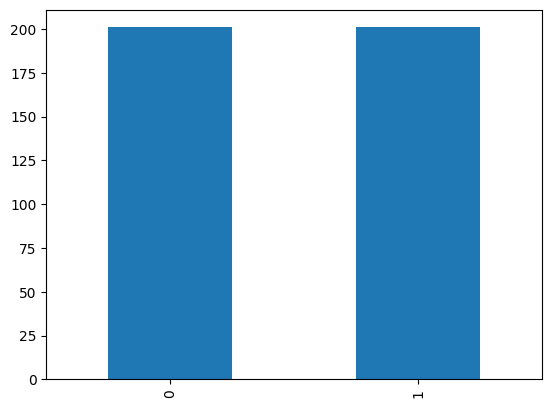

In [53]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

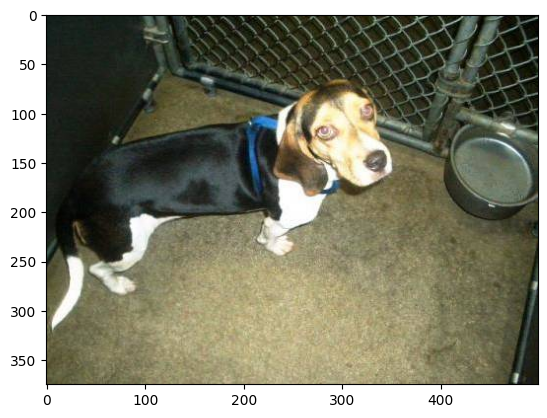

In [54]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/train/"+sample)
plt.imshow(image)

In [55]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 61, 61, 64)       

# Callbacks

In [56]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Prepare data

In [57]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [58]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

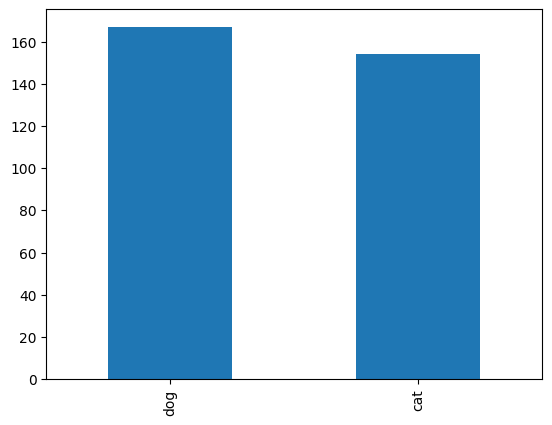

In [59]:
train_df['category'].value_counts().plot.bar()

<Axes: >

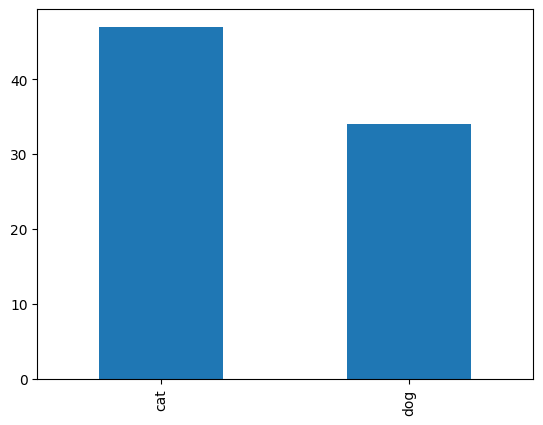

In [60]:
validate_df['category'].value_counts().plot.bar()

In [61]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [62]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 321 validated image filenames belonging to 2 classes.


### Validation Generator

In [63]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 81 validated image filenames belonging to 2 classes.


# See how our generator work

In [64]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


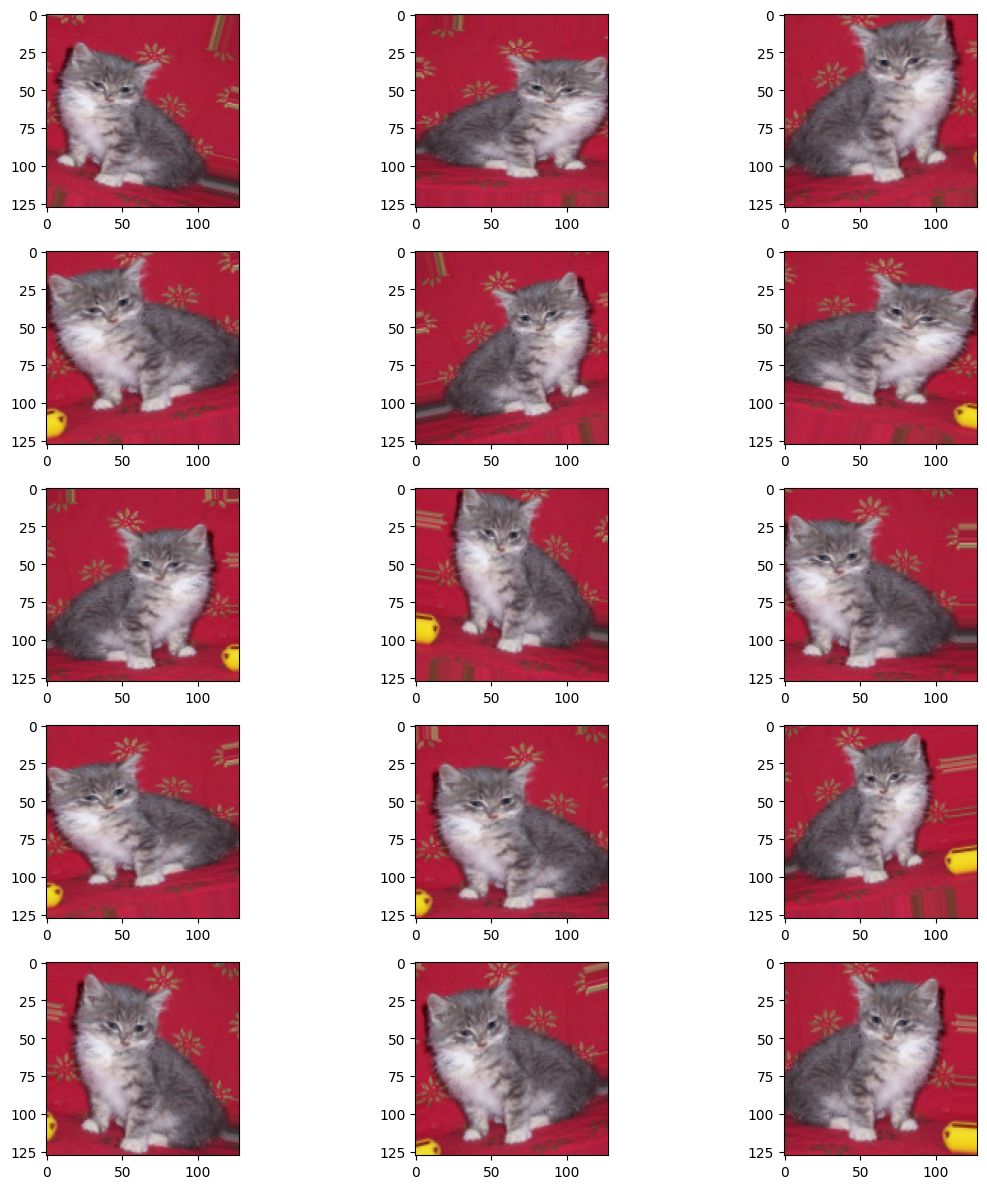

In [65]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice

# Fit Model

In [66]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

Epoch 1/50
21/21 [==============================] - 24s 1s/step - loss: 1.6066 - accuracy: 0.5752 - val_loss: 0.9283 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 21s 984ms/step - loss: 1.3721 - accuracy: 0.5425 - val_loss: 1.0046 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 21s 991ms/step - loss: 1.0718 - accuracy: 0.6013 - val_loss: 1.2760 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 21s 985ms/step - loss: 1.2177 - accuracy: 0.5523 - val_loss: 0.7259 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 22s 1s/step - loss: 0.9734 - accuracy: 0.6013 - val_loss: 0.7321 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - ETA: 0s - loss: 0.9328 - accuracy: 0.6471
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 21s 992ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Visualize Training

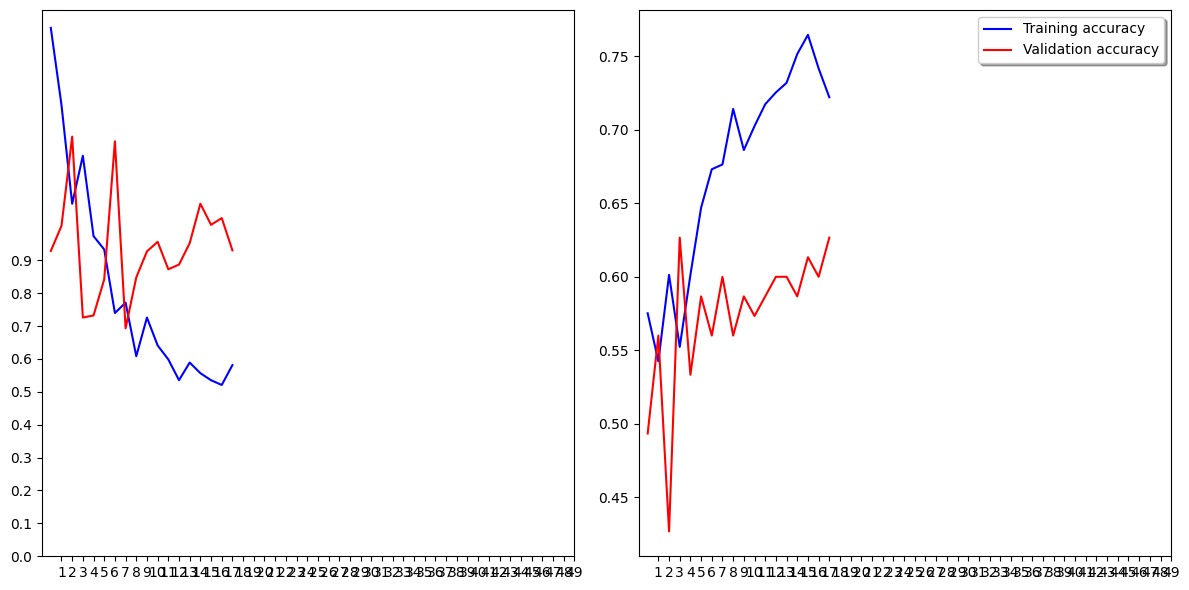

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 40ms/step
dog
1/1 [==============================] - 0s 35ms/step
dog
1/1 [==============================] - 0s 74ms/step
dog
1/1 [==============================] - 0s 58ms/step
dog
1/1 [==============================] - 0s 56ms/step
dog
1/1 [==============================] - 0s 54ms/step
dog
1/1 [==============================] - 0s 63ms/step
dog
1/1 [==============================] - 0s 59ms/step
dog
1/1 [==============================] - 0s 58ms/step
dog
1/1 [==============================] - 0s 56ms/step
dog


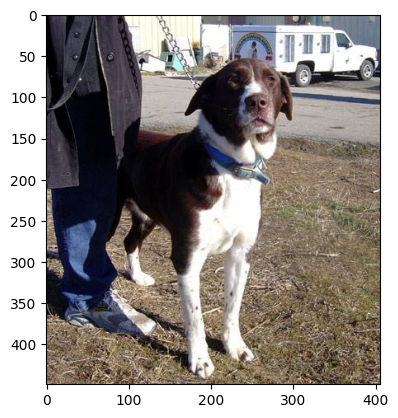

In [84]:
from google.colab.patches import cv2_imshow

for i in range(10):
    all_test_images = os.listdir("/content/drive/MyDrive/test")
    random_image = random.choice(all_test_images)
    sample_img = load_img("/content/drive/MyDrive/test/"+random_image)
    plt.imshow(sample_img)
    img = cv2.imread(f'/content/drive/MyDrive/test/{random_image}')
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))

    org= img.copy()
    img = img.reshape(1,128,128,3)

    pred = model.predict(img)
    print(['cat','dog'][int(pred[0][0])])
